In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema, ScoutingJMENanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
import math
plt.style.use(mplhep.style.CMS)

In [38]:
output = util.load("outfiles/Run3Summer22EE/fulllumi/jer_ScoutingPFMonitor_Run2022F-CHS_nonHadronicTriggers_double_noMatching.coffea")[0]

In [3]:
def resolution_centered(h, epsilon=0.1):
    
    mpv_bin = np.argmax(h.values())

    values = h.values()
    weight = values[mpv_bin]
    thesum = h.sum()
    centers = h.axes[0].centers

    best_i = -1
    best_error = epsilon

    for i in range(1, 10): #math.floor(len(values) / 2)): 
        weight += values[mpv_bin + i]
        weight += values[mpv_bin - i]

        ratio = weight / thesum

        error = abs(ratio - 0.683) 
        if error < best_error:
            best_i = i
            best_error = error
                
    return centers[mpv_bin - best_i], centers[mpv_bin + best_i], 0.5 * (centers[mpv_bin + best_i] - centers[mpv_bin - best_i])

In [4]:
def resolution(h, wmin=-0.5, wmax=0.5, epsilon=0.01):

    point = wmin
    weight = 0.0
    points = []
    # number of all jets
    thesum = h.sum()

    # number of jets in each bin
    values = h.values()

    # bin centers
    centers = h.axes[0].centers

    # fill list of bin centers and the integral up to those points
    for i, value in enumerate(values):
        weight += value
        points.append([centers[i], weight / thesum])

    low = wmin
    high = wmax

    # loop over all possible bin combninations and find the one
    # with smallest width and ~68% of all jets
    width = wmax - wmin
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
            if abs(wy - 0.683) < epsilon:
                wx = points[j][0] - points[i][0]
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    width = wx
    return low, high, 0.5 * (high - low)

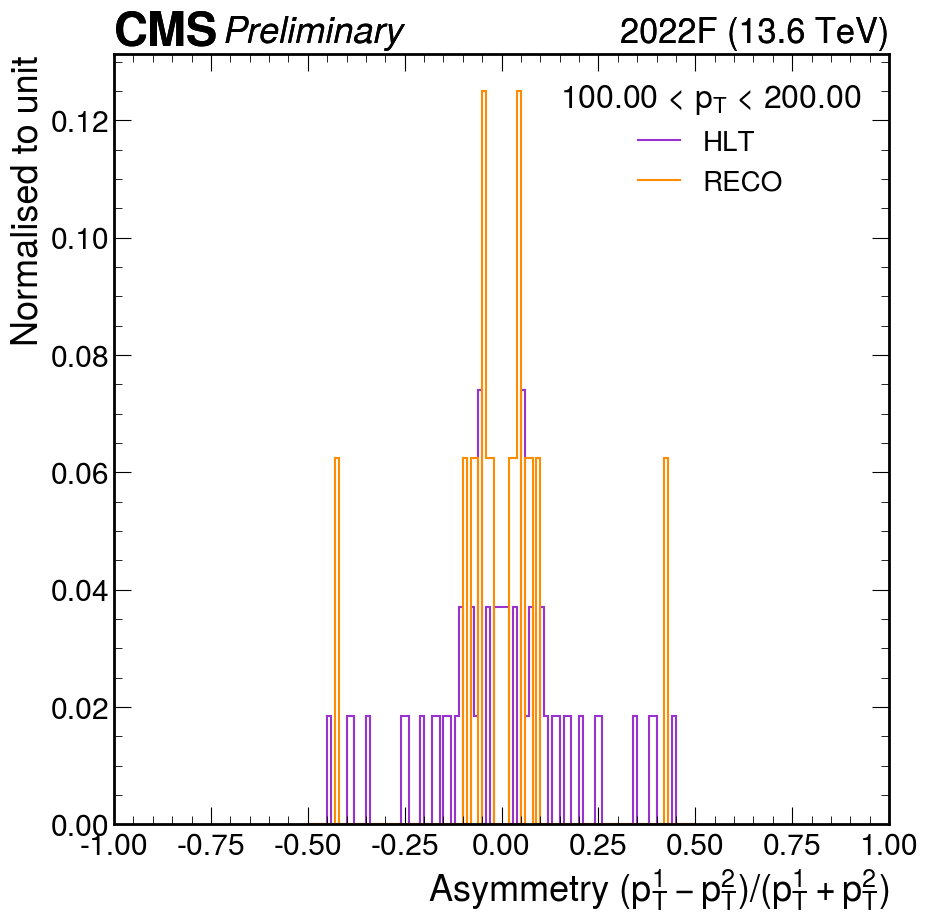

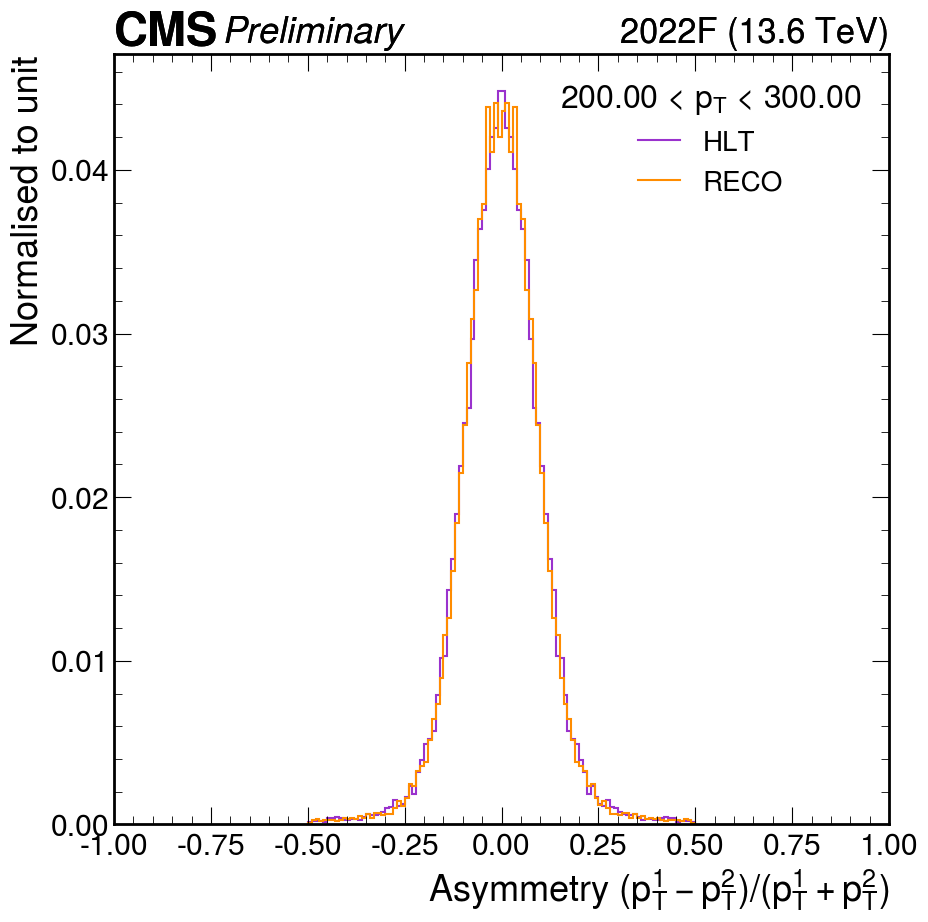

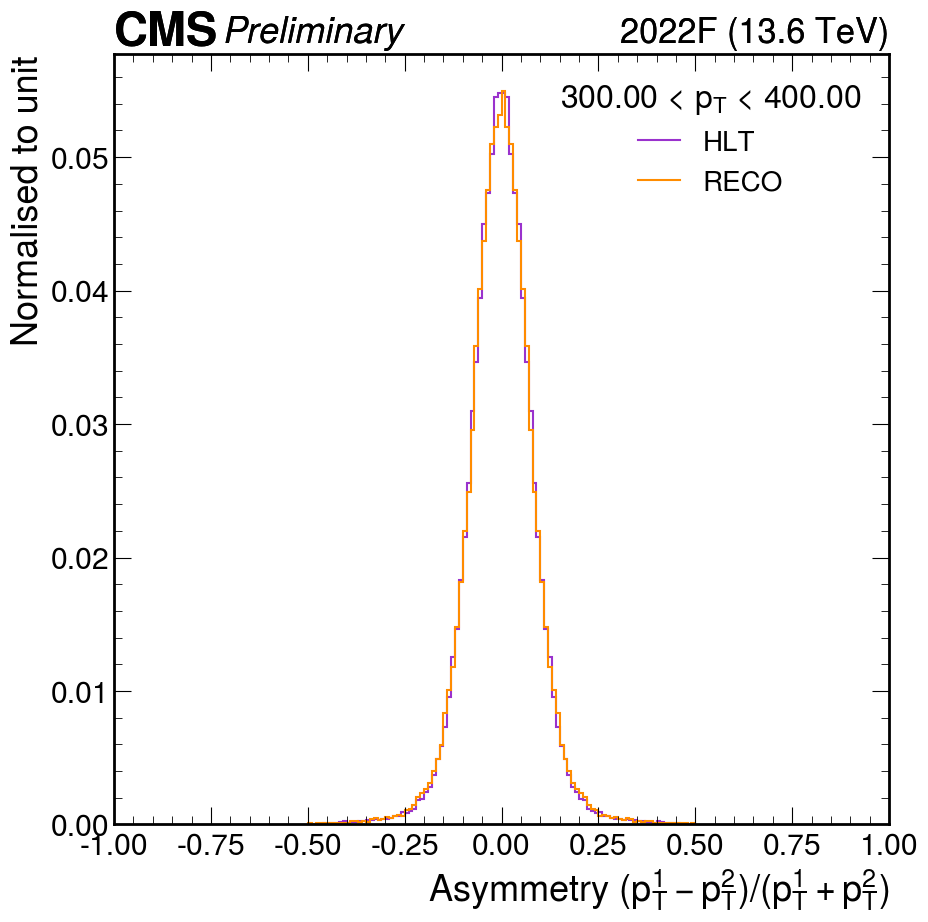

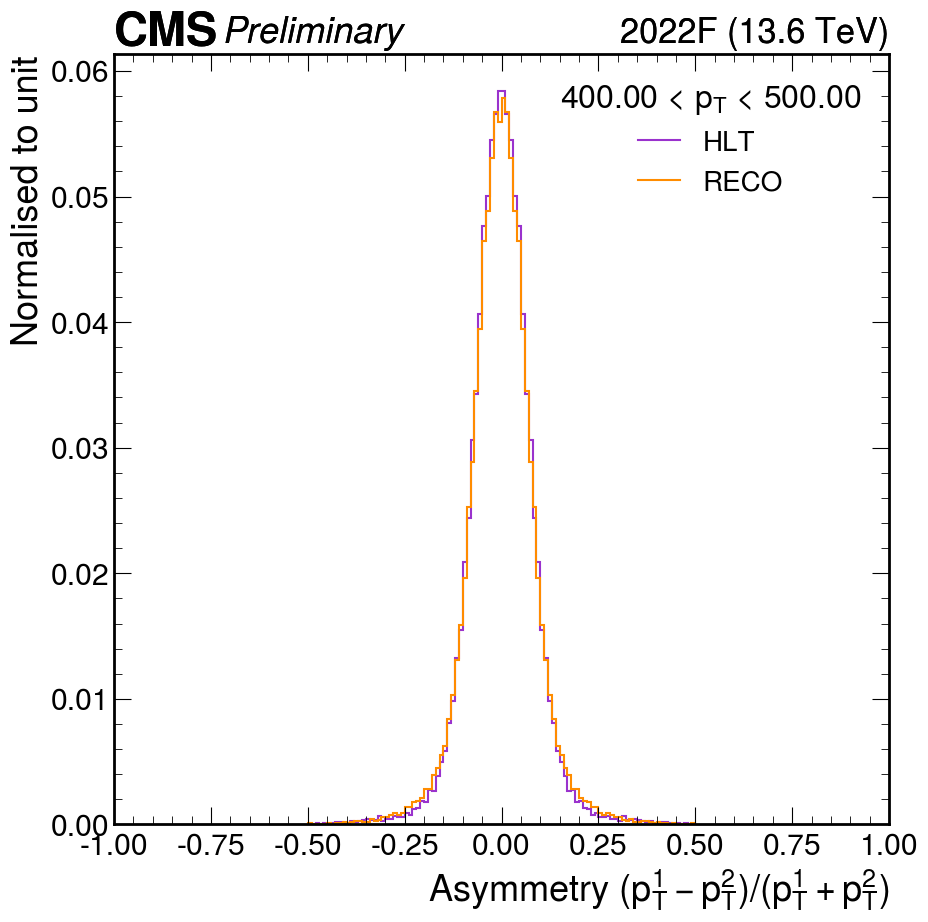

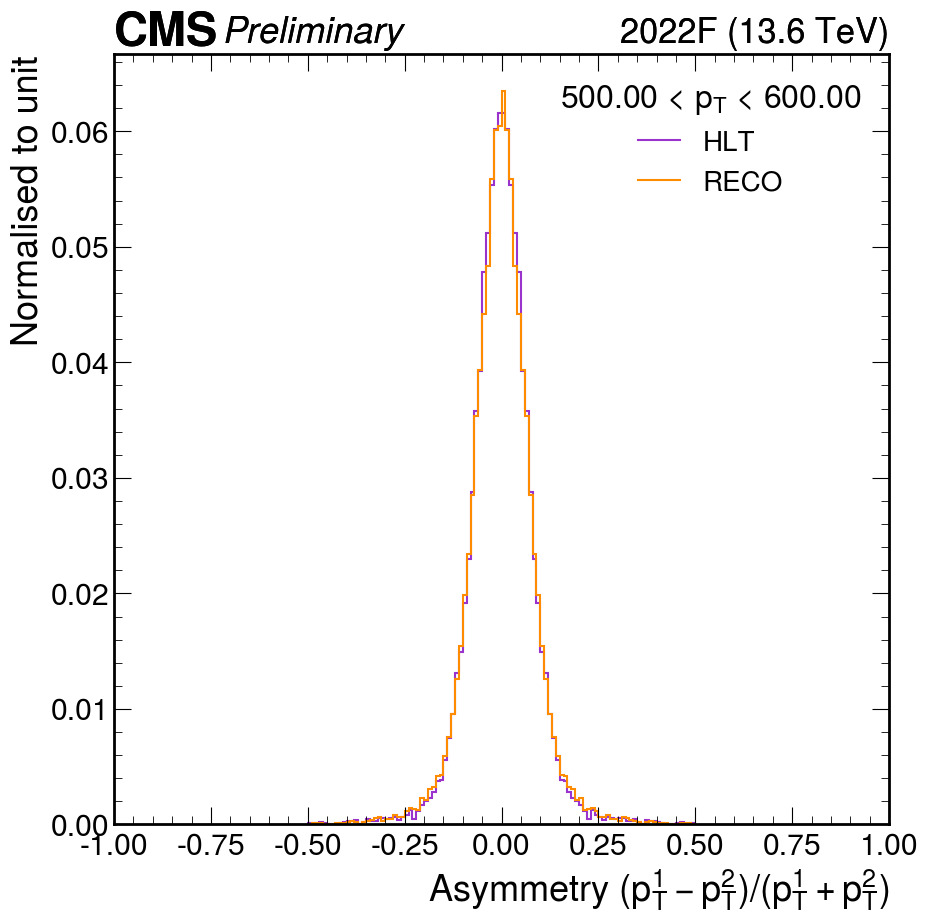

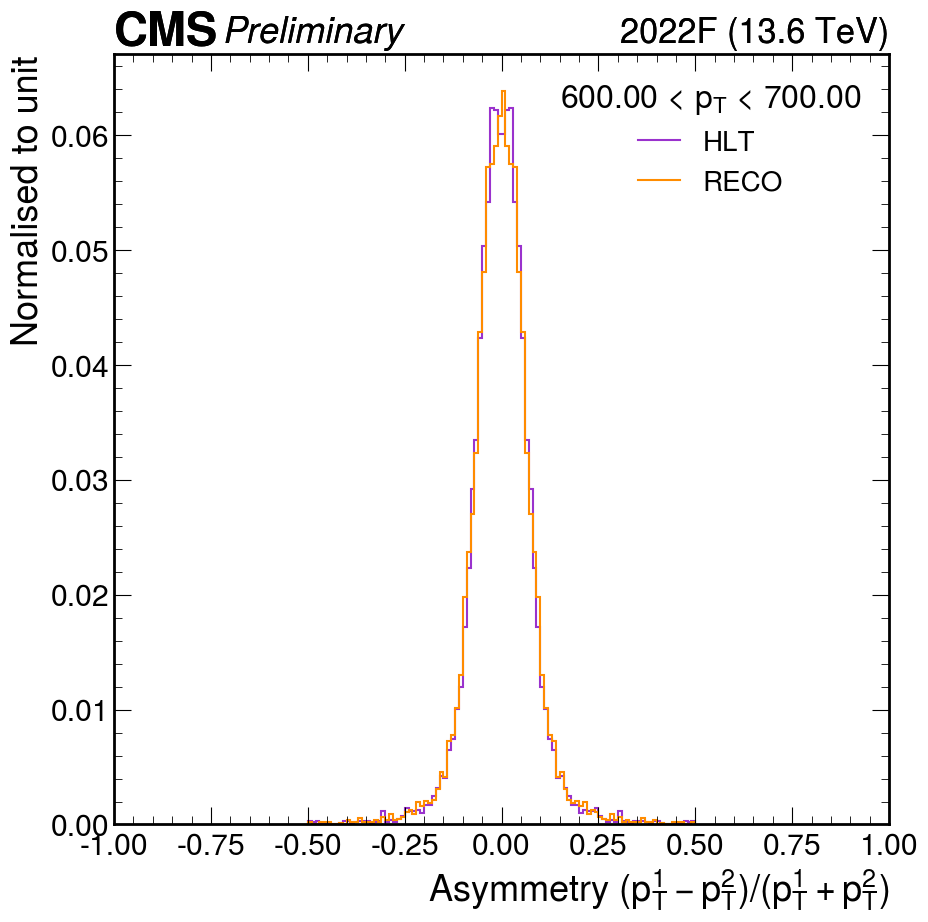

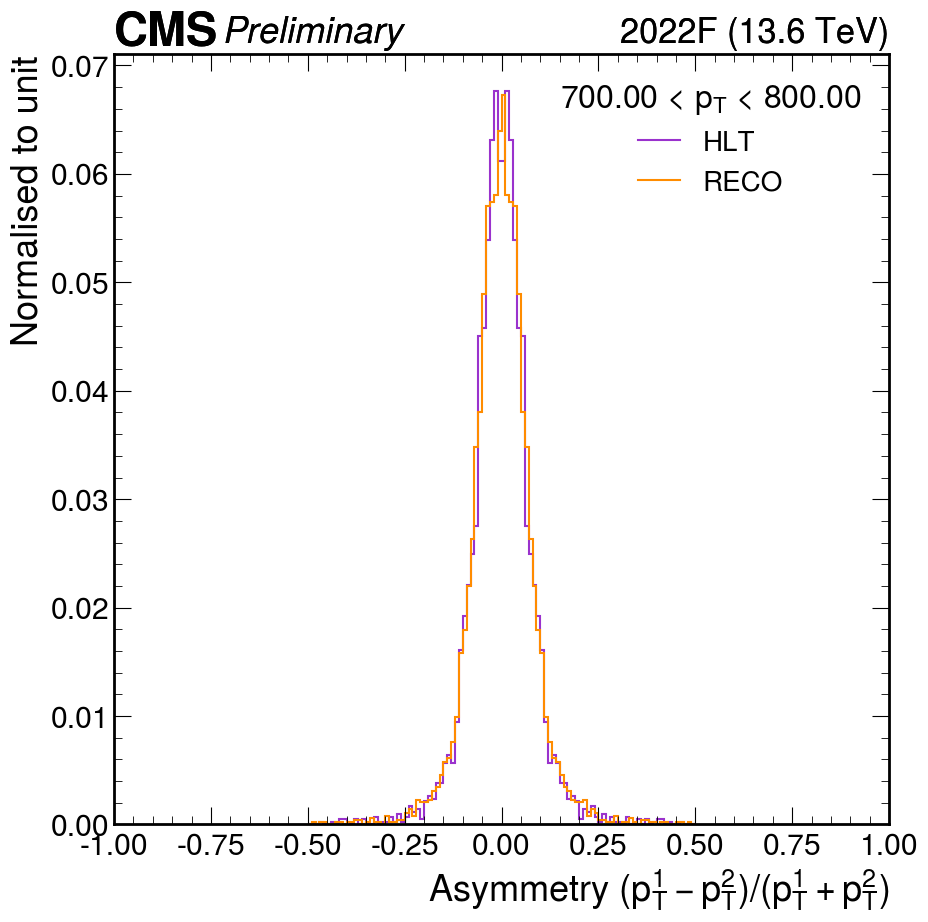

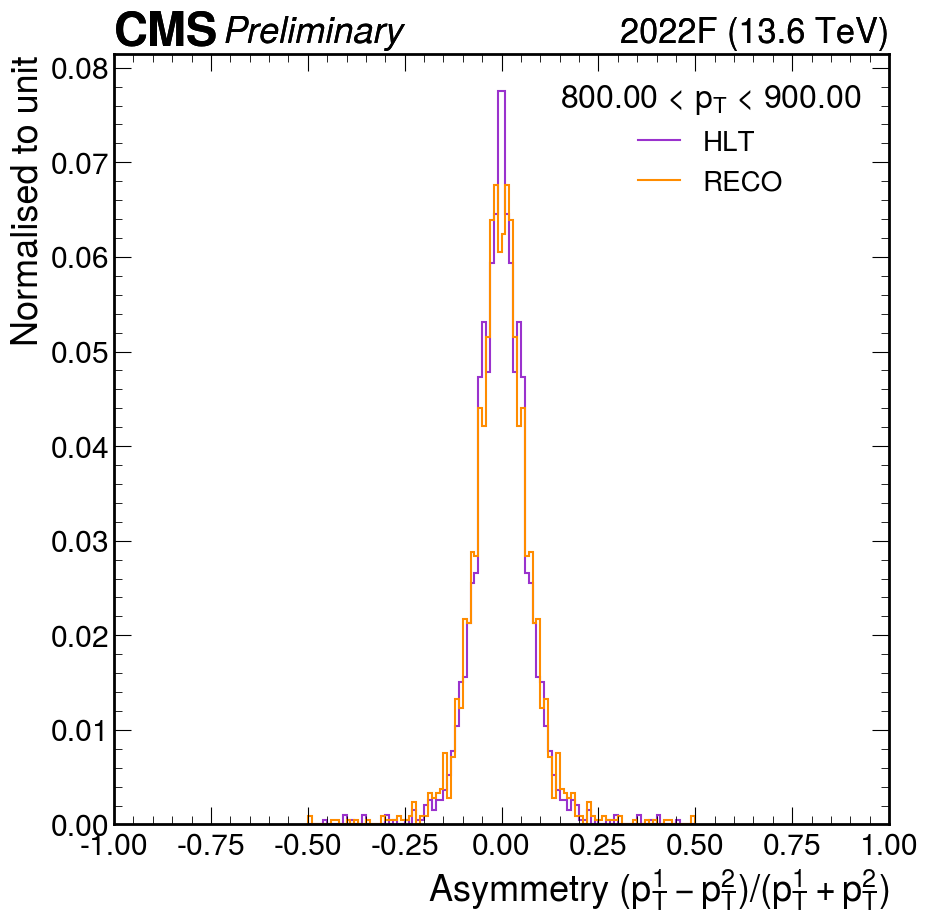

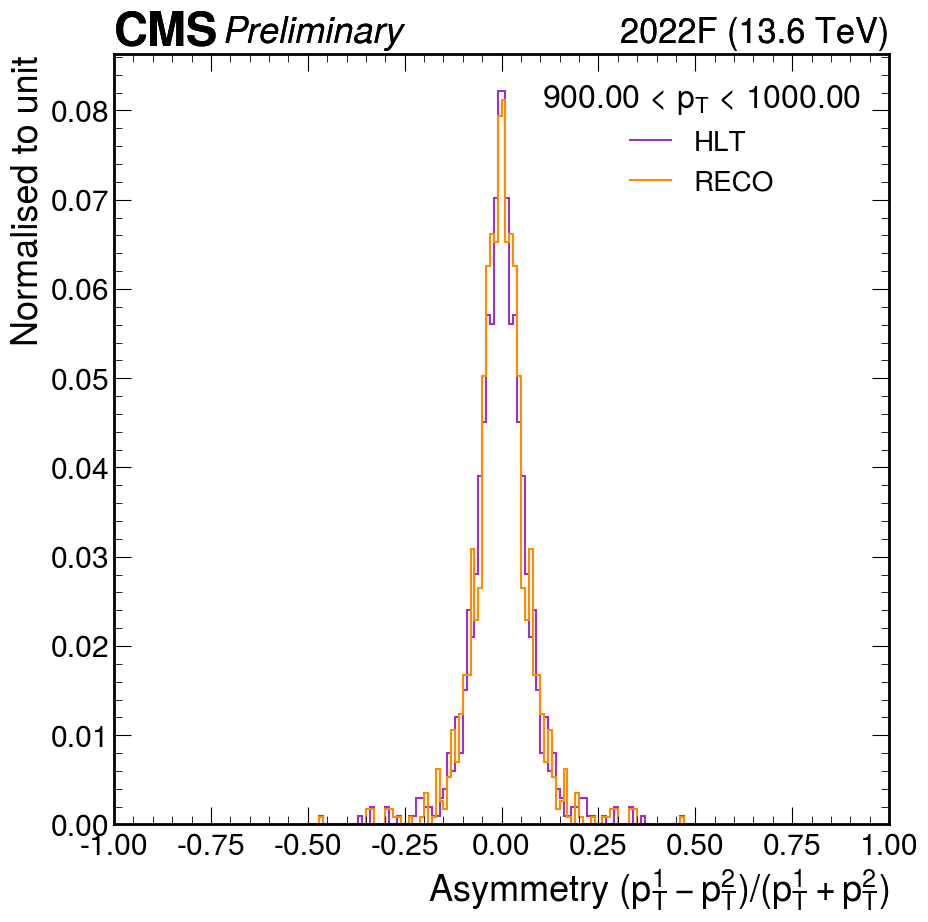

In [8]:
res_scouting = []
res_offline = []

hh = output["scouting"].project("pt_ave")[::hist.rebin(2)]
centers = hh.axes[0].centers

for i, _ in enumerate(centers):
    fig, ax = plt.subplots()
    
    for rec in ["scouting","offline"]:
    
        h = output[rec].project("asymmetry", "pt_ave")[:,::hist.rebin(2)][{"pt_ave" : i}]
        h *= 1 / h.sum() if h.sum() != 0 else 1

        mplhep.histplot(h, color="#9A32CD" if "scouting" in rec else "#FF8C00",label="HLT" if "scouting" in rec else "RECO") # + r" ($\sigma_A$" + f" = {res:.2f})")
#       ax.fill_between(edges, np.r_[h.values(), h.values()[-1]], where=np.logical_and(edges > low, edges < high), **opts)

        mplhep.cms.label(ax=ax, data=True, year="2022F", com=13.6, label="Preliminary")
        edges = hh.axes[0].edges
        ax.legend(loc="upper right", title=f"{edges[i]:.2f}" + r" < $p_T$ < " + f"{edges[i+1]:.2f}", fontsize=20, title_fontsize=23)
        ax.set_ylabel("Normalised to unit")
        ax.set_xlabel(r"Asymmetry ($p_T^1 - p_T^2 ) / (p_T^1 + p_T^2$)")
        ax.set_xlim(-1, 1)

/tmp/ipykernel_31/4104288646.py:5: RuntimeWarning: invalid value encountered in sqrt
  return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))


[None, None]

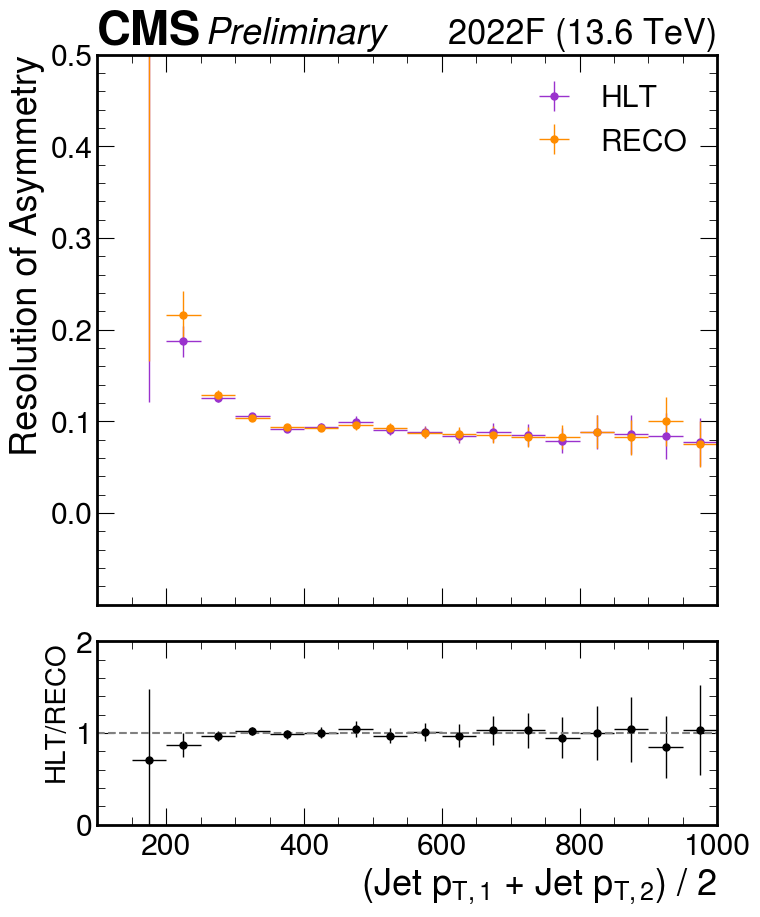

In [41]:
def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
        
    return err

fig, (ax, rax) = plt.subplots(
            2, 1, figsize=(8, 10), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
        )
fig.subplots_adjust(hspace=0.1)

hmean_s = output["scouting_mean"].project("pt_ave") #[::hist.rebin(2)]
hmean_o = output["offline_mean"].project("pt_ave") #[::hist.rebin(2)]
binwidth = hmean_s.axes[0].centers[2] - hmean_s.axes[0].centers[1]

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'elinewidth': 1,
        }

up = 10

ax.errorbar(
    hmean_s.axes[0].centers,
    err(hmean_s),
    xerr=binwidth/2,
    yerr=err_err(hmean_s)*up,
    label="HLT",
    color="#9A32CD",
    **data_err_opts,
)

ax.errorbar(
    hmean_o.axes[0].centers,
    err(hmean_o),
    xerr=binwidth/2,
    yerr=err_err(hmean_o)*up,
    label="RECO",
    color="#FF8C00",
    **data_err_opts,
)

rax.errorbar(
    hmean_s.axes[0].centers,
    err(hmean_s)/err(hmean_o),
    xerr=binwidth/2,
    yerr=err_prop(err(hmean_s), err(hmean_o), err_err(hmean_s)*up, err_err(hmean_o)*up),
    **data_err_opts,
    color="black",
)

ax.legend(loc="best")
mplhep.cms.label(ax=ax, data=True, year="2022F", com=13.6, label="Preliminary")
ax.set_ylabel(r"Resolution of Asymmetry")
ax.set_xlabel("")
rax.set_xlabel(r"(Jet $p_{T,1}$ + Jet $p_{T,2}$) / 2")
rax.set_ylabel("HLT/RECO", fontsize=20)
rax.axhline(1, color='gray',ls='--')
rax.set_xlim(100, 1000)
rax.set_ylim(0, 2)
ax.set_ylim(-0.1, 0.5)
plt.setp(ax.get_yticklabels()[0], visible=False)

/tmp/ipykernel_31/1750663506.py:5: RuntimeWarning: invalid value encountered in sqrt
  return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(1, 0, 'Jet $p_{T}$ (GeV)')

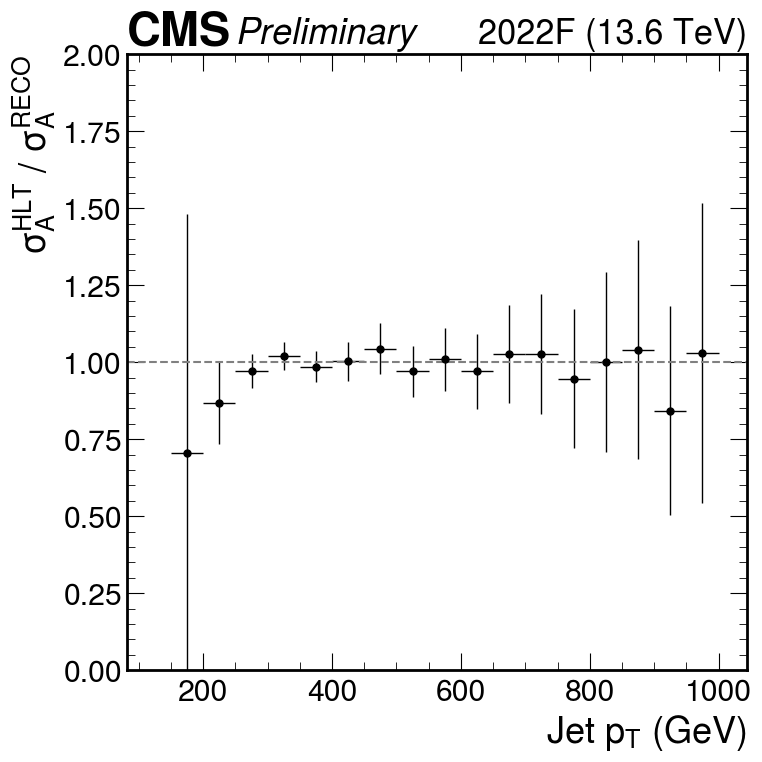

In [40]:
def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

fig, ax = plt.subplots(figsize=(8, 8))

hmean_s = output["scouting_mean"].project("pt_ave") #[::hist.rebin(2)]
hmean_o = output["offline_mean"].project("pt_ave") #[::hist.rebin(2)]
binwidth = hmean_s.axes[0].centers[2] - hmean_s.axes[0].centers[1]

up = 10

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            #'color': 'k',
            'elinewidth': 1,
        }

ax.errorbar(
    hmean_s.axes[0].centers,
    err(hmean_s)/err(hmean_o),
    xerr=binwidth/2,
    yerr=err_prop(err(hmean_s), err(hmean_o), err_err(hmean_s)*up, err_err(hmean_o)*up),
    **data_err_opts,
    color="black",
)

ax.axhline(1, color='gray',ls='--')

ax.legend(loc="best")
mplhep.cms.label(ax=ax, data=True, year="2022F", com=13.6, label="Preliminary")
ax.set_ylabel(r"$\sigma_A^{HLT}$ / $\sigma_A^{RECO}$")
ax.set_xlabel("")
ax.set_ylim(0, 2)
ax.set_xlabel(r"Jet $p_{T}$ (GeV)")

In [42]:
lep = util.load("outfiles/Run3Summer22EE/fulllumi/jer_ScoutingPFMonitor_Run2022F-CHS_nonHadronicTriggers_double_noMatching.coffea")[0]
had = util.load("outfiles/Run3Summer22EE/fulllumi/jer_ScoutingPFMonitor_Run2022F_jetid.coffea")[0]

/tmp/ipykernel_31/2402240269.py:5: RuntimeWarning: invalid value encountered in sqrt
  return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))


[None, None]

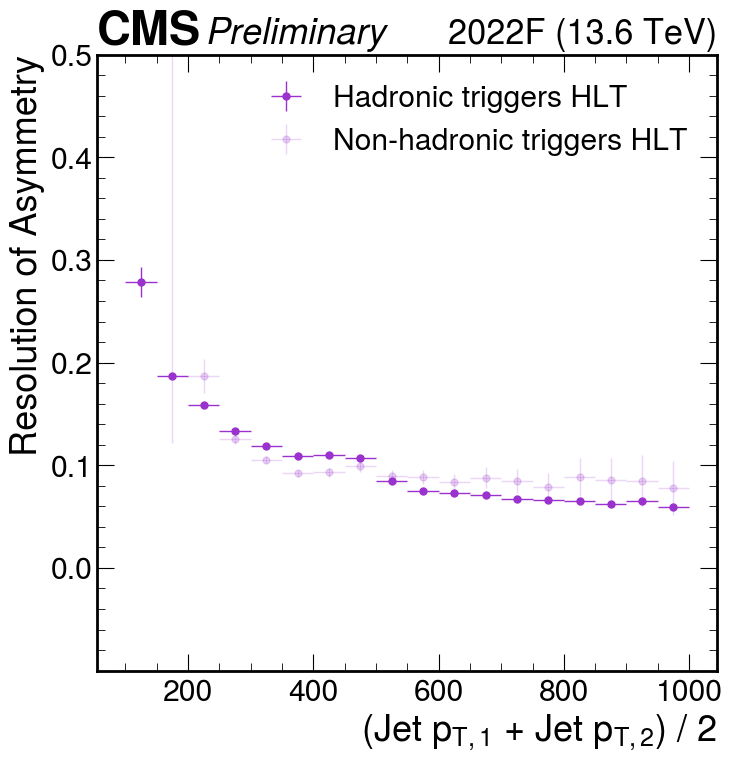

In [43]:
def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
        
    return err

fig, ax = plt.subplots(figsize=(8,8))

hmean_s_lep = lep["scouting_mean"].project("pt_ave") #[::hist.rebin(2)]
hmean_o_lep = lep["offline_mean"].project("pt_ave") #[::hist.rebin(2)]
hmean_s_had = had["scouting_mean"].project("pt_ave") #[::hist.rebin(2)]
hmean_o_had = had["offline_mean"].project("pt_ave") #[::hist.rebin(2)]
binwidth = hmean_s_lep.axes[0].centers[2] - hmean_s_lep.axes[0].centers[1]

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'elinewidth': 1,
        }

ax.errorbar(
    hmean_s_had.axes[0].centers,
    err(hmean_s_had),
    xerr=binwidth/2,
    yerr=err_err(hmean_s_had),
    label="Hadronic triggers HLT",
    color="#9A32CD",
    **data_err_opts,
)

ax.errorbar(
    hmean_s_lep.axes[0].centers,
    err(hmean_s_lep),
    xerr=binwidth/2,
    yerr=err_err(hmean_s_lep)*10,
    label="Non-hadronic triggers HLT",
    color="#9A32CD",
    **data_err_opts,
    alpha=0.2,
)

ax.legend(loc="best")
mplhep.cms.label(ax=ax, data=True, year="2022F", com=13.6, label="Preliminary")
ax.set_ylabel(r"Resolution of Asymmetry")
ax.set_xlabel(r"(Jet $p_{T,1}$ + Jet $p_{T,2}$) / 2")
ax.set_ylim(-0.1, 0.5)
plt.setp(ax.get_yticklabels()[0], visible=False) 

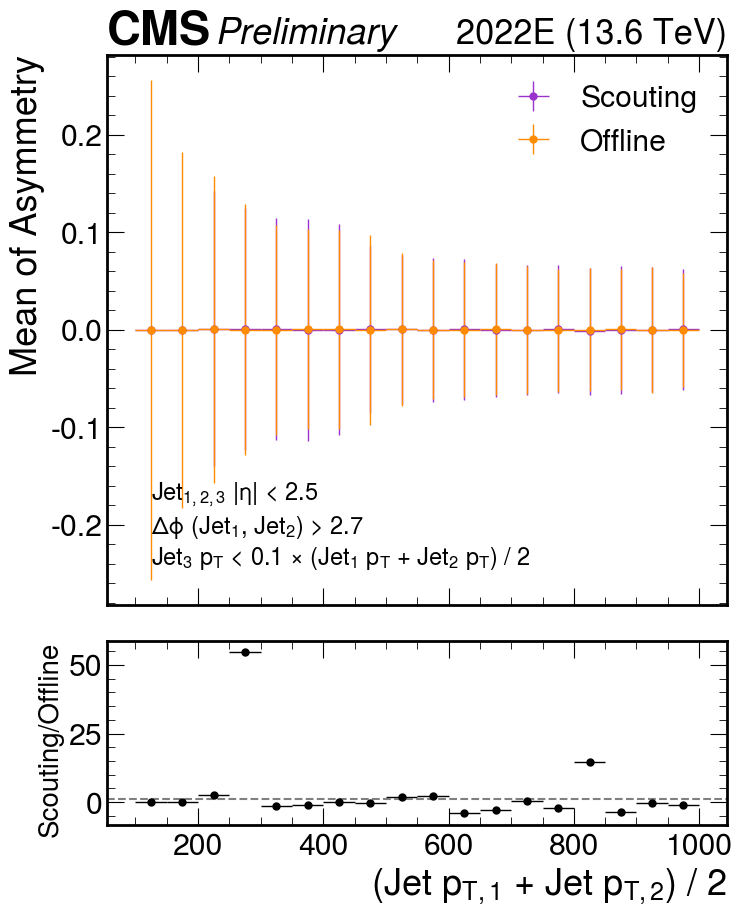

In [115]:
def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

fig, (ax, rax) = plt.subplots(
            2, 1, figsize=(8, 10), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
        )
fig.subplots_adjust(hspace=0.1)

hmean_s = output["scouting_mean"].project("pt_ave")
hmean_o = output["offline_mean"].project("pt_ave")
binwidth = hmean_s.axes[0].centers[2] - hmean_s.axes[0].centers[1]

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            #'color': 'k',
            'elinewidth': 1,
        }

ax.errorbar(
    hmean_s.axes[0].centers,
    hmean_s.values(),
    xerr=binwidth/2,
    yerr=err(hmean_s),
    label="Scouting",
    color="#9A32CD",
    **data_err_opts,
)

ax.errorbar(
    hmean_o.axes[0].centers,
    hmean_o.values(),
    xerr=binwidth/2,
    yerr=err(hmean_o),
    label="Offline",
    color="#FF8C00",
    **data_err_opts,
)

rax.errorbar(
    hmean_s.axes[0].centers,
    hmean_s.values()/hmean_o.values(),
    xerr=binwidth/2,
    yerr=err(hmean_s)/err(hmean_o),
    **data_err_opts,
    color="black",
)

ax.legend(loc="best")
mplhep.cms.label(ax=ax, data=True, year="2022F", com=13.6, label="Preliminary")
ax.text(0.07, 0.06, r"Jet$_{1, 2, 3}$ |$\eta$| < 2.5" + "\n" + r"$\Delta \phi$ (Jet$_1$, Jet$_2$) > 2.7" + "\n" + r"$Jet_3$ $p_T$ < 0.1 $\times$ ($Jet_1$ $p_T$ + $Jet_2$ $p_T$) / 2",
        fontsize=17,
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes
       )
ax.set_ylabel(r"Mean of Asymmetry")
ax.set_xlabel("")
rax.set_xlabel(r"(Jet $p_{T,1}$ + Jet $p_{T,2}$) / 2")
rax.set_ylabel("Scouting/Offline", fontsize=20)
rax.axhline(1, color='gray',ls='--')

In [155]:
from scipy.optimize import curve_fit

def gaussfit(
    x : np.ndarray,
    y : np.ndarray):
    
    def gauss_function(x, a, mean, sigma):
        return a*np.exp(-(x - mean)**2/(2 * sigma**2))
    
    # initial guess
    mean = 1.0
    sigma = np.sqrt(sum((x - mean)**2) / len(x))
    
    p, pcov = curve_fit(gauss_function, x, y, p0 = [1, mean, sigma])
    
    # parameter error
    perr = np.sqrt(np.diag(pcov))
    
    return (p, perr)

In [156]:
h = output["scouting"].project("pt_ave", "asymmetry")

bins = h.axes[0].centers
nbins = len(bins)

res = []
reserr = []

for i in range(nbins):
    
    h_bin = h[i, :]
    x = h_bin.axes[0].centers
    y = h_bin.values()
    
    p, perr = gaussfit(x, y)
    res.append(p[2])
    reserr.append(perr[2])

(0.0, 0.5)

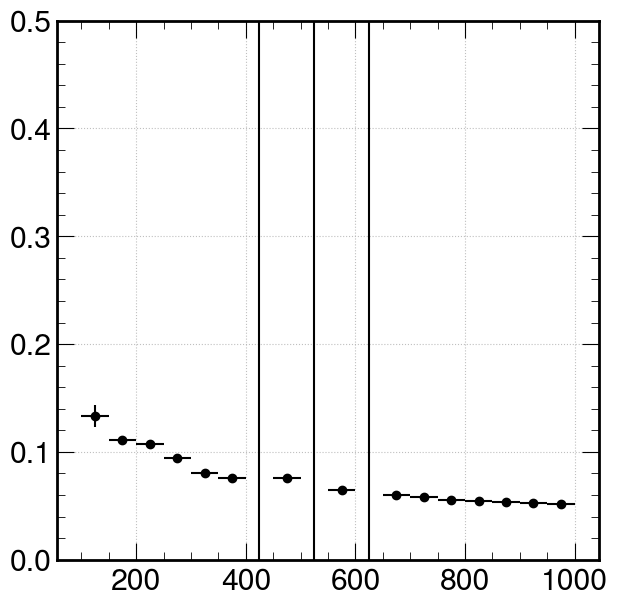

In [160]:
fig, ax = plt.subplots(figsize=(7,7),)

ax.errorbar(bins, np.abs(res), xerr=abs((bins[0]-bins[1])/2), yerr=reserr, fmt='o', color="black")
ax.grid()
ax.set_ylim(0, 0.5)